In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread("./002.jpg")

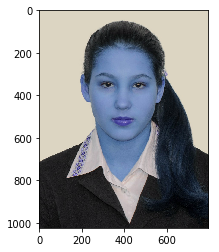

In [2]:
plt.imshow(img);

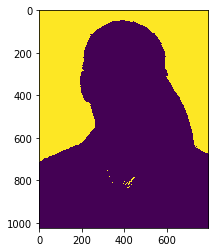

In [3]:
color = img[10, 10]

lower_border = np.array(list(color - 10), dtype = "uint16")
upper_border = np.array(list(color + 10), dtype = "uint16")
black_mask = cv.inRange(img, lower_border, upper_border)
plt.imshow(black_mask);

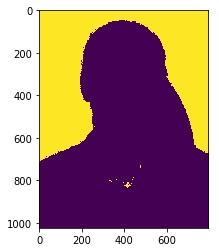

In [4]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_TRIANGLE)
plt.imshow(thresh);

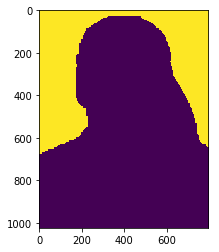

In [5]:
bg_sure = cv.erode(thresh, None, iterations=20)
# ret, bg_sure = cv.threshold(bg_sure, 1, 128, 1)
plt.imshow(bg_sure);

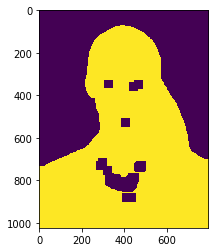

In [6]:
fg_sure = cv.dilate(thresh, None, iterations=20)
ret, fg = cv.threshold(fg_sure, 1, 128, 1)
plt.imshow(fg);

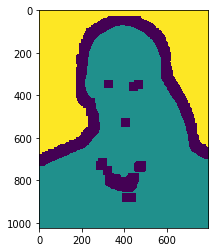

In [7]:
marker = cv.add(fg, bg_sure)
plt.imshow(marker);

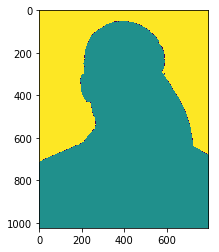

In [8]:
marker32 = np.int32(marker)
cv.watershed(img, marker32)
m = cv.convertScaleAbs(marker32)
plt.imshow(m);

In [9]:
m[m == 255] = 123
m[m == 128] = 255
m[m == 123] = 128
m

array([[  1,   1,   1, ...,   1,   1,   1],
       [  1, 128, 128, ..., 128, 128,   1],
       [  1, 128, 128, ..., 128, 128,   1],
       ...,
       [  1, 255, 255, ..., 255, 255,   1],
       [  1, 255, 255, ..., 255, 255,   1],
       [  1,   1,   1, ...,   1,   1,   1]], dtype=uint8)

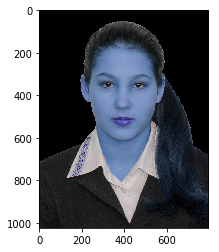

In [10]:
img_copy = img.copy()
ret, thresh = cv.threshold(m, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
result = cv.bitwise_and(img_copy, img_copy, mask=thresh)
plt.imshow(result);

# Make pipeline

In [11]:
def switch_bg_and_fg(mask: np.ndarray) -> np.ndarray:
    __temp_val = 123
    __true = 255
    __false = 128
    mask[mask == __true] = __temp_val
    mask[mask == __false] = __true
    mask[mask == __temp_val] = __false
    return mask

def rm_bg(path: str, iterations_count: int = 20) -> np.ndarray:
    # Now there will be some regions in the original image where you are simply sure, 
    # that part belong to bg. Mark such region with 255 in marker image. 
    # Now the region where you are sure to be the fg are marked with 128. 
    # The region you are not sure are marked with 0.
    __sure = 255
    __not_sure = 0
    __sure_not = 128
    
    # load image
    img = cv.imread(path)
    
    # get bg mask by treshlod (like all pixels lighter than ..)
    gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 0, __sure, cv.THRESH_TRIANGLE)
    plt.imshow(thresh);
    
    # reduce bg area, for remove some small areas in face/clothe
    bg_sure = cv.erode(thresh, None, iterations=iterations_count)
    
    # increace foreground area
    fg_sure = cv.dilate(thresh, None, iterations=iterations_count)
    
    # mark fg with 128 value
    _, fg = cv.threshold(fg_sure, 1, __sure_not, 1)
    
    # combine them to one mask with markers: 255, 128, 0
    marker = cv.add(fg, bg_sure)
    
    marker32 = np.int32(marker)
    cv.watershed(img, marker32)
    mask = cv.convertScaleAbs(marker32)
    
    mask = switch_bg_and_fg(mask)
    
    img_copy = img.copy()
    _, thresh = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    result = cv.bitwise_and(img_copy, img_copy, mask=thresh)
    
    return result

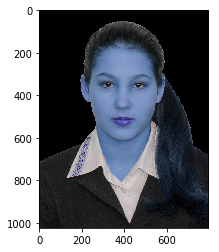

In [12]:
result = rm_bg("./002.jpg")
plt.imshow(result);